## Carga de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from pathlib import Path
import warnings
from scipy.stats import gaussian_kde
from statsmodels.tsa.seasonal import seasonal_decompose

ModuleNotFoundError: No module named 'geopandas'

In [2]:
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 6)})
PROCESSED_PATH = Path("datos_procesados.parquet")

# *Carga y procesamiento de datos*

In [ ]:
class AccidentDataLoader:
    CRS_PROJECTED = "EPSG:3857"
    
    def __init__(self, filepath):
        self.filepath = filepath
        self.gdf = None
    
    def _load_raw_data(self):
        df = pd.read_csv(self.filepath, low_memory=False)
        print(f"Datos cargados: {df.shape}")  
        df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
        df = df.dropna(subset=['Start_Time', 'Start_Lat', 'Start_Lng'])
        print(f"Datos después de eliminar nulos: {df.shape}")  
        return df
    
    def _spatial_processing(self, df):
        print("Ejecutando _spatial_processing...")  

        print("Primeras filas del DataFrame:")
        print(df.head())  

        print("Verificando columnas de latitud y longitud:")
        print(df[['Start_Lat', 'Start_Lng']].head())  

        print("Valores nulos:")
        print(df[['Start_Lat', 'Start_Lng']].isna().sum())  

        print("Estadísticas de las coordenadas:")
        print(df[['Start_Lat', 'Start_Lng']].describe())  

        
        if 'Start_Lat' in df.columns and 'Start_Lng' in df.columns:
            gdf = gpd.GeoDataFrame(
                df,
                geometry=gpd.points_from_xy(df.Start_Lng, df.Start_Lat),
                crs="EPSG:4326"
            )

            print(f"CRS original: {gdf.crs}")
            gdf = gdf.to_crs(self.CRS_PROJECTED)
            print(f"CRS proyectado: {gdf.crs}")

            return gdf
        else:
            print("ERROR: No se encontraron las columnas necesarias en el DataFrame.")
            return None
    
    def load_data(self):
        print("Ejecutando load_data()...")  
        if PROCESSED_PATH.exists():
            print("Cargando datos desde caché...")
            self.gdf = gpd.read_parquet(PROCESSED_PATH)
            return self.gdf
        
        print("Cargando datos sin procesar...")
        df = self._load_raw_data()

        print("Llamando a _spatial_processing()...")
        gdf = self._spatial_processing(df)  

        if gdf is None:
            print("ERROR: _spatial_processing() devolvió None")
            return None

        print("Guardando datos procesados...")
        gdf.to_parquet(PROCESSED_PATH)
        
        self.gdf = gdf
        return self.gdf

# *Transformación de los datos*

In [ ]:
def prepare_accident_data(gdf, grid_size=0.1):
    gdf['Fecha_Hora'] = gdf['Start_Time'].dt.floor('h')
    
    x_min, y_min = gdf.geometry.x.min(), gdf.geometry.y.min()
    gdf['Zona_X'] = ((gdf.geometry.x - x_min) // grid_size).astype(int)
    gdf['Zona_Y'] = ((gdf.geometry.y - y_min) // grid_size).astype(int)
    
    df_grouped = gdf.groupby(['Fecha_Hora', 'Zona_X', 'Zona_Y']).size().reset_index(name='Accidentes')
    
    visibility_avg = gdf.groupby(['Fecha_Hora', 'Zona_X', 'Zona_Y'])['Visibility(km)'].mean().reset_index()
    
    df_grouped = df_grouped.merge(visibility_avg, on=['Fecha_Hora', 'Zona_X', 'Zona_Y'], how='left')
    
    print(df_grouped.head()) 
    return df_grouped

# *Análisis exploratorio regresivo*

In [ ]:
def plot_spatial_heatmap(gdf):
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf = gdf.to_crs(epsg=3857)
    
    gdf.plot(ax=ax, markersize=1, alpha=0.5, color='red')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title("Mapa de Accidentes")
    plt.show()

In [6]:
def plot_hourly_distribution(df):
    df['Hora'] = df['Fecha_Hora'].dt.hour
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Hora', y='Accidentes', data=df, palette='coolwarm')
    plt.title("Distribución de Accidentes por Hora del Día")
    plt.xlabel("Hora del Día")
    plt.ylabel("Número de Accidentes")
    plt.show()

In [7]:
def plot_day_of_week_distribution(df):
    df['Dia_Semana'] = df['Fecha_Hora'].dt.dayofweek
    dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Dia_Semana', y='Accidentes', data=df, palette='viridis')
    plt.xticks(ticks=range(7), labels=dias)
    plt.title("Distribución de Accidentes por Día de la Semana")
    plt.xlabel("Día de la Semana")
    plt.ylabel("Número de Accidentes")
    plt.show()

In [8]:
def plot_target_distribution(df):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df['Accidentes'], bins=30, kde=True, color='teal')
    plt.title("Distribución de la Variable Objetivo")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df['Accidentes'], color='orange')
    plt.title("Boxplot de Accidentes")

    plt.tight_layout()
    plt.show()

# *Análisis de patrones espacio-temporales*

In [ ]:
def plot_time_series_analysis(df):
    df['Hora'] = df['Fecha_Hora'].dt.hour
    df['Dia'] = df['Fecha_Hora'].dt.date
    df['Mes'] = df['Fecha_Hora'].dt.to_period('M').astype(str)
    
    fig, ax = plt.subplots(3, 1, figsize=(14, 12))
    
    # Por hora
    hourly = df.groupby('Hora')['Accidentes'].sum()
    sns.lineplot(x=hourly.index, y=hourly.values, ax=ax[0], color='#E74C3C')
    ax[0].set_title("Accidentes por Hora del Día")
    
    # Por día
    daily = df.groupby('Dia')['Accidentes'].sum()
    sns.lineplot(x=daily.index, y=daily.values, ax=ax[1], color='#3498DB')
    ax[1].set_title("Tendencia Diaria de Accidentes")
    
    # Por mes
    monthly = df.groupby('Mes')['Accidentes'].sum()
    sns.lineplot(x=monthly.index, y=monthly.values, ax=ax[2], color='#2ECC71')
    ax[2].set_title("Tendencia Mensual de Accidentes")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [10]:
def identify_peak_times(df):
    
    hourly = df.groupby(df['Fecha_Hora'].dt.hour)['Accidentes'].sum()
    hourly_peak = hourly.idxmax()

    daily = df.groupby(df['Fecha_Hora'].dt.dayofweek)['Accidentes'].sum()
    daily_peak = daily.idxmax()
    
    dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    
    print(f"\nHora pico: {hourly_peak}:00")
    print(f"Día pico: {dias[daily_peak]}")
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.barplot(x=hourly.index, y=hourly.values, ax=ax[0], palette='Reds')
    ax[0].set_title("Accidentes por Hora")
    ax[0].set_xlabel("Hora del Día")
    ax[0].set_ylabel("Número de Accidentes")
    
    sns.barplot(x=dias, y=daily.values, ax=ax[1], palette='Blues')
    ax[1].set_title("Accidentes por Día de la Semana")
    ax[1].set_xlabel("Día de la Semana")
    ax[1].set_ylabel("Número de Accidentes")
    
    plt.tight_layout()
    plt.show()

# *Análisis de factores de riesgo*

In [ ]:
def analyze_infrastructure_impact(gdf):
    infra_vars = [
        'Crossing', 'Junction', 'Traffic_Signal', 'Roundabout',
        'Station', 'Stop', 'Bump', 'Railway', 'Give_Way',
        'Traffic_Calming', 'Amenity', 'No_Exit'
    ]
    
    plt.figure(figsize=(14, 8))
    
    presence = gdf[infra_vars].mean().sort_values(ascending=False)
    sns.barplot(x=presence.values, y=presence.index, palette='viridis')
    plt.title('Frecuencia de Características de Infraestructura en Accidentes')
    plt.xlabel('Proporción de Accidentes con la Característica')
    plt.xlim(0, 1)
    plt.show()
    
 
    plt.figure(figsize=(14, 6))
    for i, var in enumerate(infra_vars, 1):
        plt.subplot(3, 4, i)
        sns.boxplot(x=var, y='Severity', data=gdf, palette='coolwarm')
        plt.title(f'Severidad vs {var}')
        plt.xticks([0, 1], ['No', 'Sí'])
    
    plt.tight_layout()
    plt.show()
    
    print("\nRiesgo Relativo (Presencia vs Ausencia):")
    risk_df = []
    for var in infra_vars:
        temp = gdf.groupby(var)['Severity'].agg(['count', 'mean'])
        risk = temp.loc[1, 'count']/temp.loc[0, 'count'] if 1 in temp.index else np.nan
        risk_df.append({
            'Característica': var,
            'RR Total': temp.loc[1, 'count']/temp.loc[0, 'count'] if 1 in temp.index else np.nan,
            'RR Severidad': temp.loc[1, 'mean']/temp.loc[0, 'mean'] if 1 in temp.index else np.nan
        })
    
    risk_df = pd.DataFrame(risk_df).set_index('Característica')
    print(risk_df.sort_values('RR Total', ascending=False))

In [12]:
def analyze_weather_impact(gdf):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.regplot(x='Visibility(km)', y='Accidentes', 
               data=gdf, ax=ax[0], scatter_kws={'alpha':0.3})
    ax[0].set_title("Relación Visibilidad-Accidentes")

    if 'Wind_Speed(km/h)' in gdf.columns:
        sns.boxplot(x=pd.qcut(gdf['Wind_Speed(km/h)'], 5), 
                   y='Accidentes', data=gdf, ax=ax[1])
        ax[1].set_title("Accidentes por Velocidad del Viento")
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [13]:
def descomponer_serie_temporal(df, columna_tiempo='Fecha_Hora', periodo=7, modelo='additive'):
    
    df[columna_tiempo] = pd.to_datetime(df[columna_tiempo])
    df.set_index(columna_tiempo, inplace=True)

    df_daily = df.resample('D').size()
    
    decomposed = seasonal_decompose(df_daily, model=modelo, period=periodo)
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    decomposed.observed.plot(ax=axes[0], title="Serie Original")
    decomposed.trend.plot(ax=axes[1], title="Tendencia")
    decomposed.seasonal.plot(ax=axes[2], title="Estacionalidad")
    decomposed.resid.plot(ax=axes[3], title="Residuos")
    plt.show()
    
    return decomposed

Ejecutando load_data()...
Cargando datos desde caché...
           Fecha_Hora  Zona_X  Zona_Y  Accidentes  Visibility(km)
0 2016-01-14 20:00:00     491     160           7           16.09
1 2016-02-08 00:00:00     415     155           1           16.09
2 2016-02-08 05:00:00     405     153           2           16.09
3 2016-02-08 06:00:00     400     145           1           16.09
4 2016-02-08 06:00:00     401     145           1           16.09
           Fecha_Hora  Zona_X  Zona_Y  Accidentes  Visibility(km)
0 2016-01-14 20:00:00     491     160           7           16.09
1 2016-02-08 00:00:00     415     155           1           16.09
2 2016-02-08 05:00:00     405     153           2           16.09
3 2016-02-08 06:00:00     400     145           1           16.09
4 2016-02-08 06:00:00     401     145           1           16.09


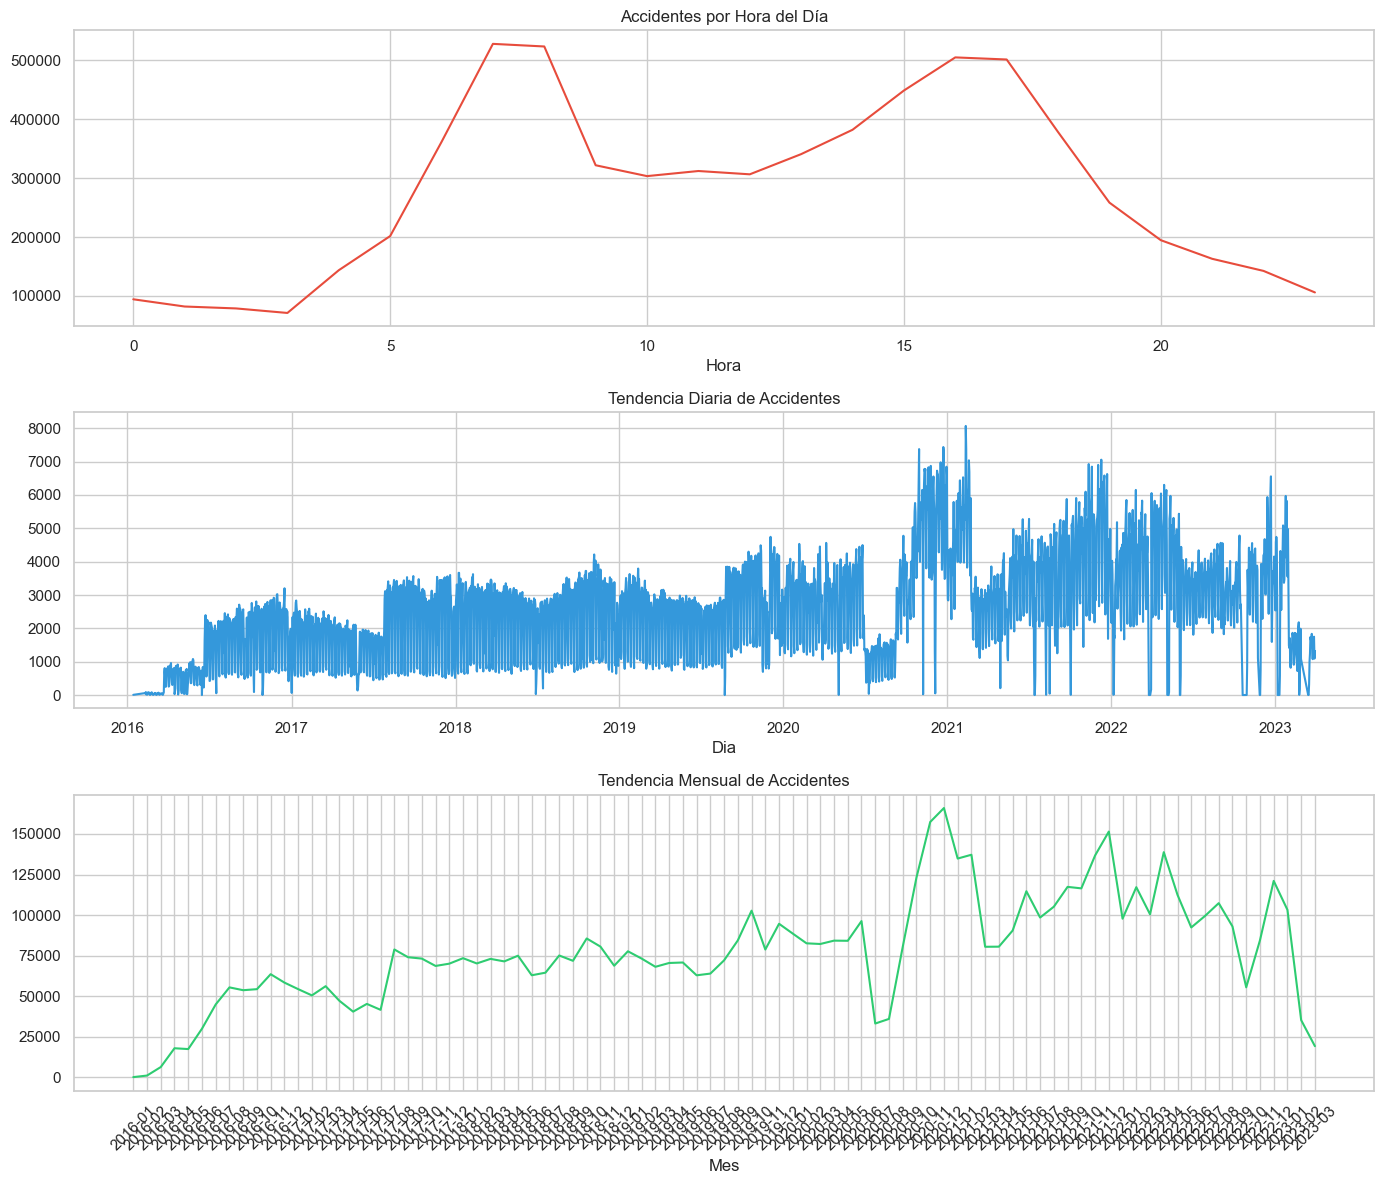

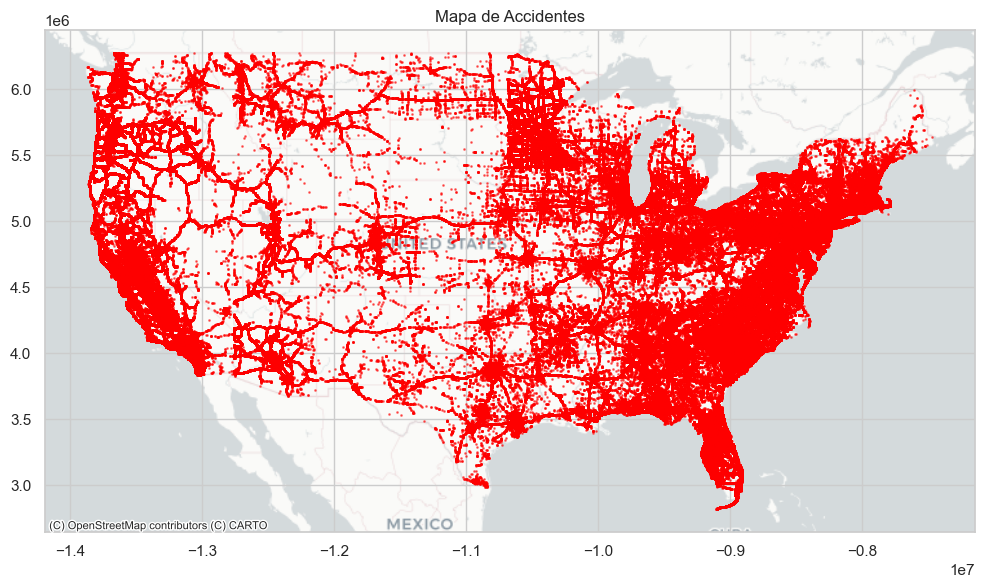


Hora pico: 7:00
Día pico: Viernes


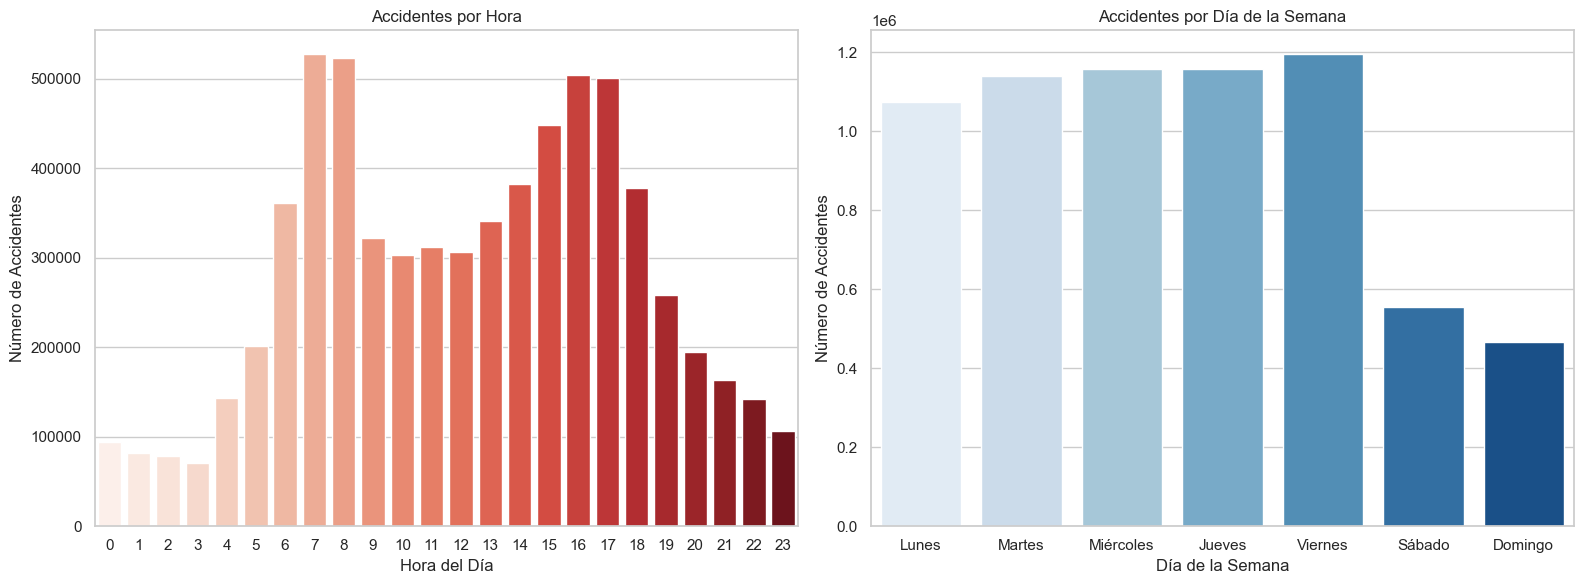

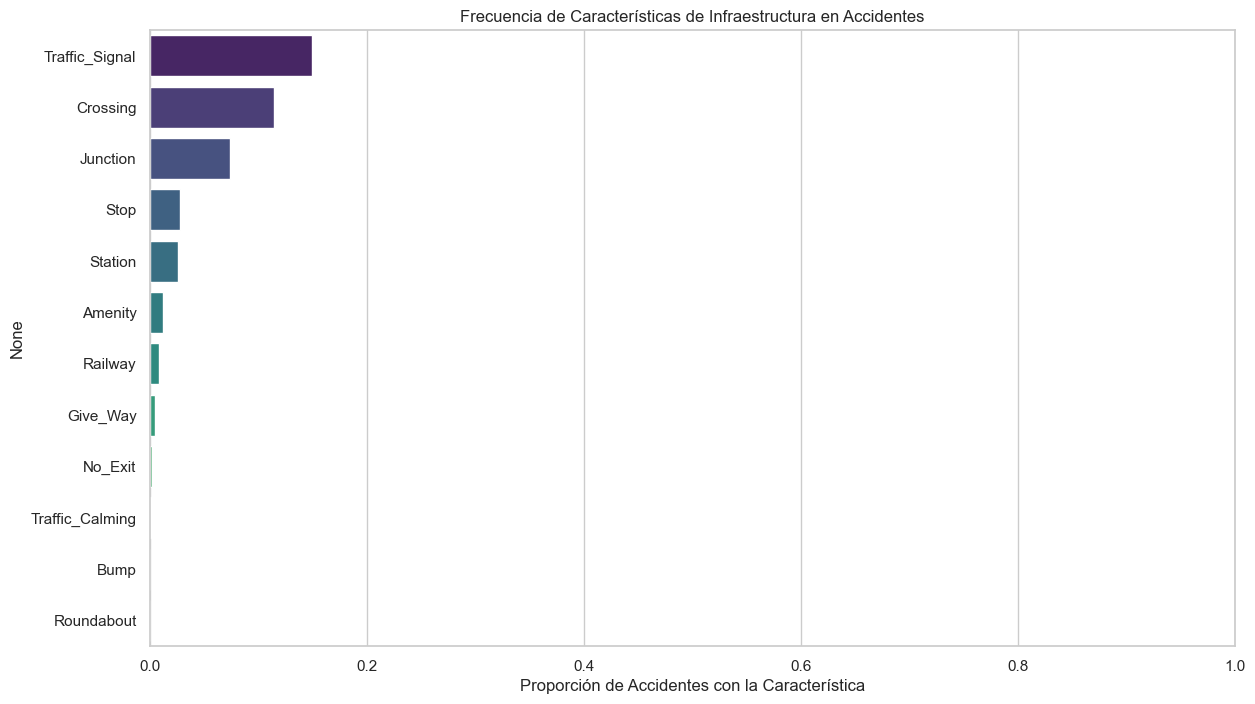

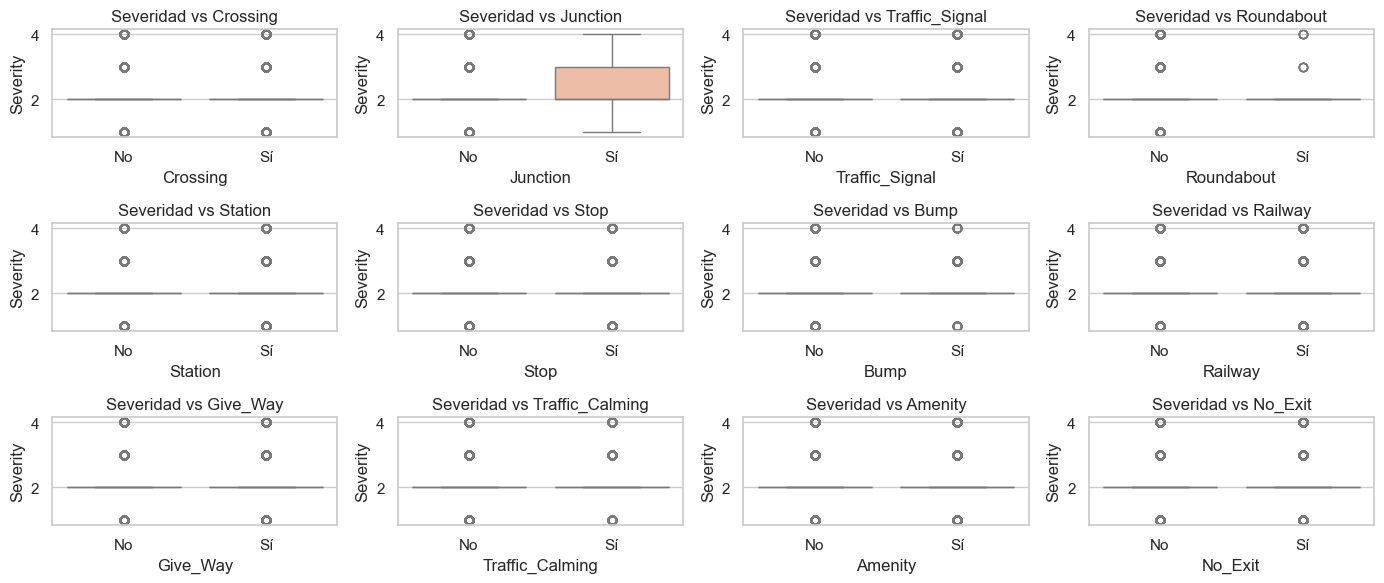


Riesgo Relativo (Presencia vs Ausencia):
                 RR Total  RR Severidad
Característica                         
Crossing              NaN           NaN
Junction              NaN           NaN
Traffic_Signal        NaN           NaN
Roundabout            NaN           NaN
Station               NaN           NaN
Stop                  NaN           NaN
Bump                  NaN           NaN
Railway               NaN           NaN
Give_Way              NaN           NaN
Traffic_Calming       NaN           NaN
Amenity               NaN           NaN
No_Exit               NaN           NaN


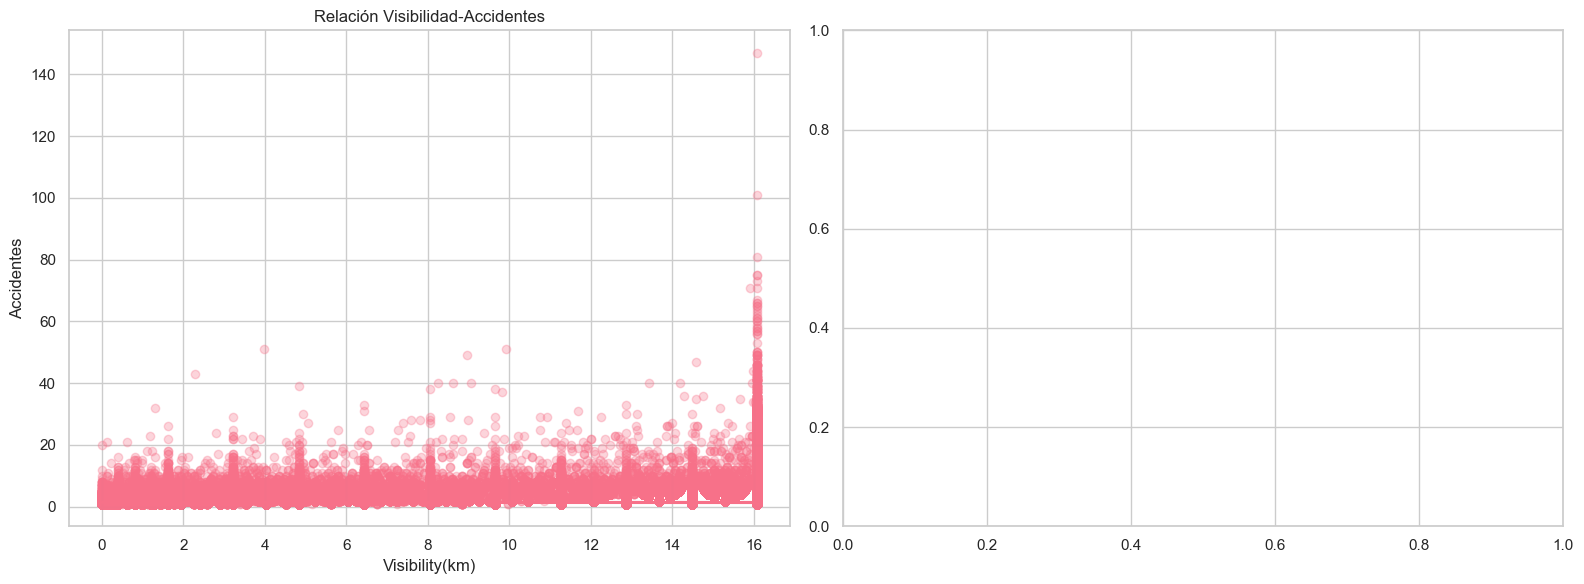

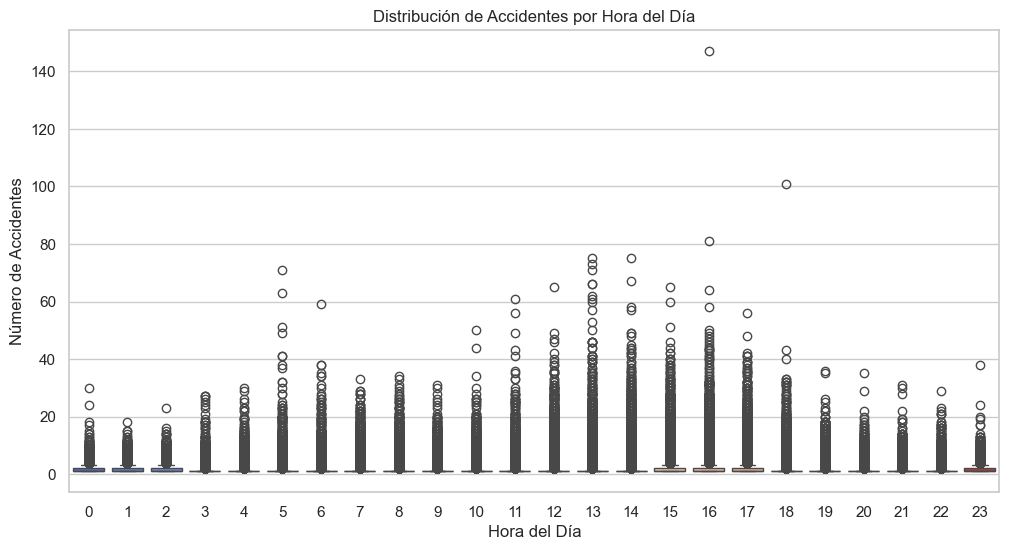

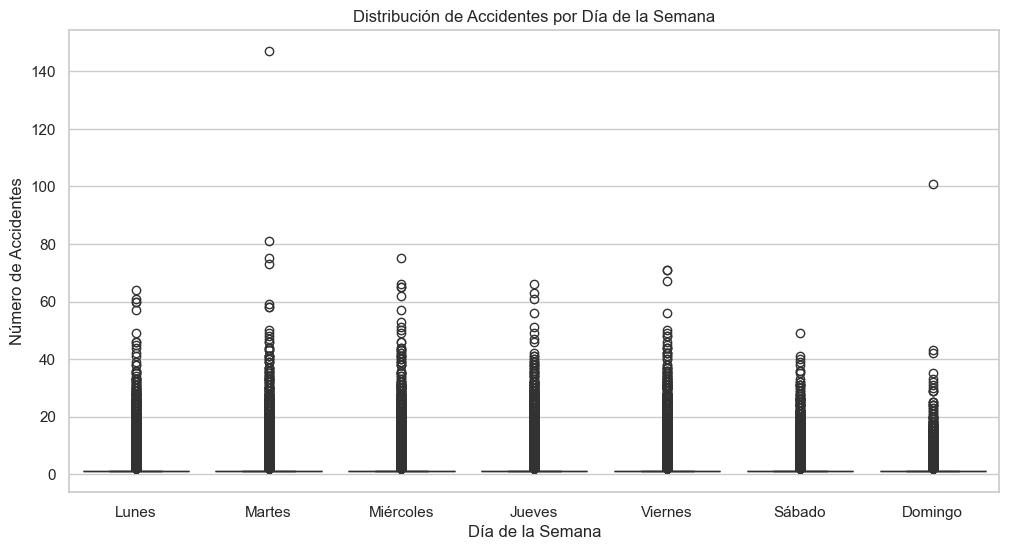

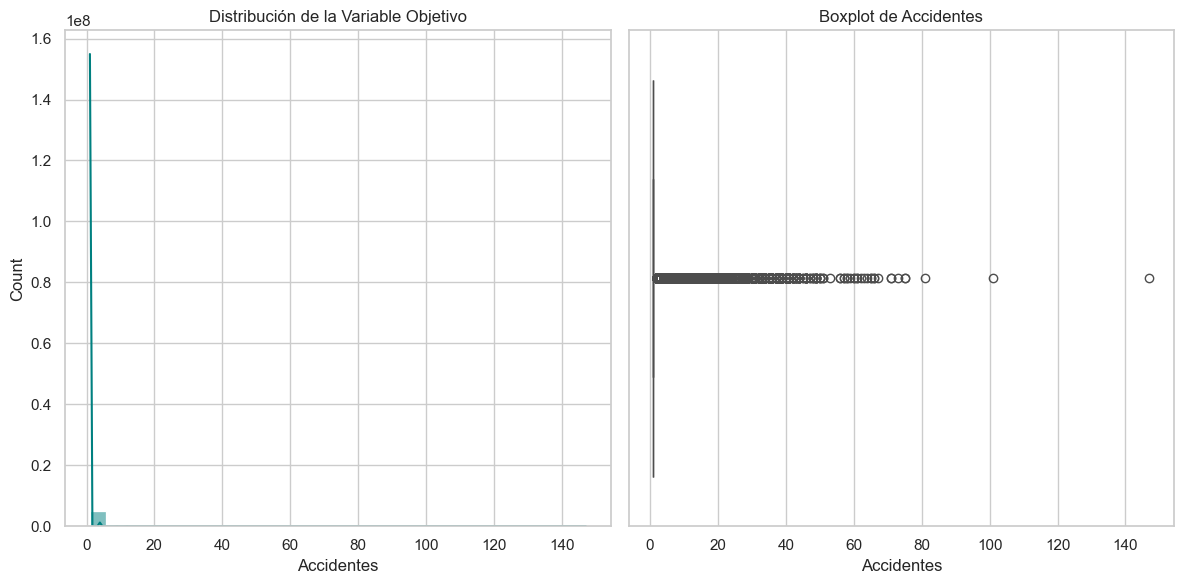

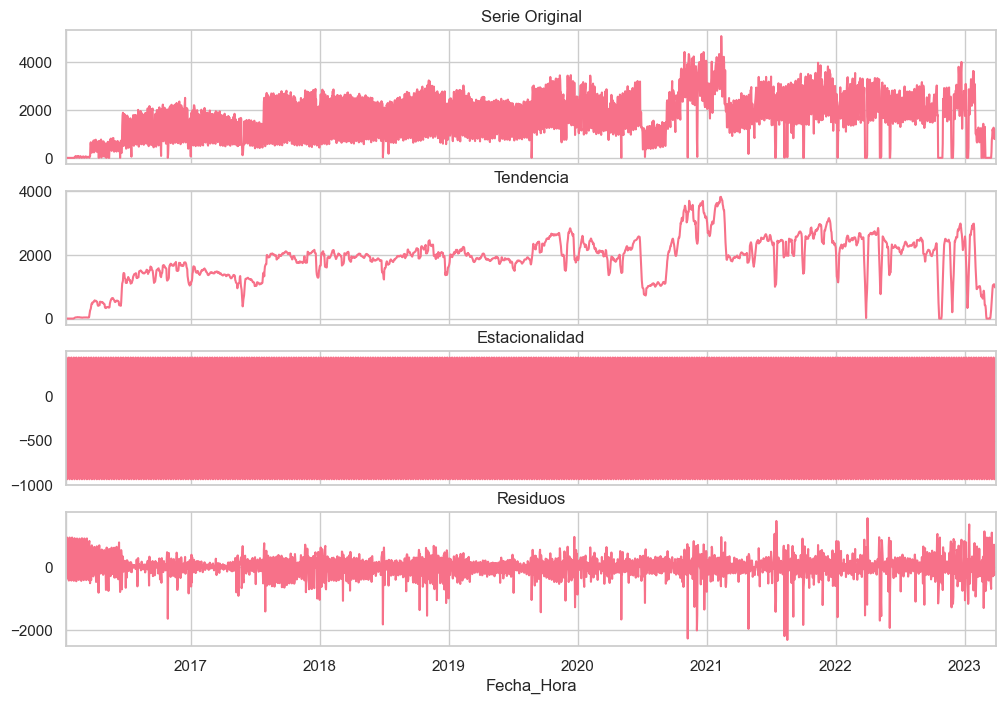

In [ ]:
#Ejecución principal
if __name__ == "__main__":
    
    loader = AccidentDataLoader("accidentes.csv")
    gdf = loader.load_data()
    
    df_accidentes = prepare_accident_data(gdf)
    
    print(df_accidentes.head())
    
    plot_time_series_analysis(df_accidentes)
    plot_spatial_heatmap(gdf)
    identify_peak_times(df_accidentes)
    
    analyze_infrastructure_impact(gdf)
    analyze_weather_impact(df_accidentes)

    plot_hourly_distribution(df_accidentes)
    plot_day_of_week_distribution(df_accidentes)
    plot_target_distribution(df_accidentes)
    descomponer_serie_temporal(df_accidentes)